---
title: "딥러닝 소개 - 심층 신경망 훈련하기"
date: 2020-07-17T18:00:47+09:00
tags:
  - "Basic Data Structures"
  - "Python Basic"
  - "Python"
  - "iteration"
categories:
  - "function"
  - "Python"
  - "Python Basic"
menu: 
  kaggle:
    name: 딥러닝 소개 - 심층 신경망 훈련하기
---


## 공지 
- 본 Tutorial은 교재 `핸즈온 머신러닝 2판`를 활용하여 본 강사로부터 국비교육 강의를 듣는 사람들에게 자료 제공을 목적으로 제작하였습니다.

- 강사의 주관적인 판단으로 압축해서 자료를 정리하였기 때문에, 자세하게 공부를 하고 싶은 분은 반드시 교재를 구매하실 것을 권해드립니다. 
> 책 정말 좋습니다! 꼭 구매하세요!

<!-- ![](/img/python_edu/07_deeplearning/handsOn_logo.jpg#center) -->

## 개요
- 인경 신경망은(`Artificial Neural Network`)을 촉발시킨 근원임
  + 뇌에 있는 생물학적 뉴런의 네트워크에서 영감을 받은 머신러닝 모델
- 활용예제
  + 수백만개의 이미지 분류
  + 수백만개의 비디어 추천
  + 매우 복잡한 문제를 풀 때 유용한 머신러닝 모델
- Keras API
  + 케라스는 신경망 구축, 훈련, 평가, 실행을 목적으로 설계된 API이자, 프레임워크


### (1) 주요 환경 설정
- 주요 환경 설정은 아래와 같이 정의합니다. 

In [48]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## I. 그레이디언트 소실과 폭주
- 소실: 경사 하강법이 하위층의 연결 가중치를 변경되지 않은 채로 둔다면 안타깝게도 훈련이 좋은 솔루션으로 수렴되지 않음. 
- 폭주: 그레이디언트가 점점 커져서 여러 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘은 발산함. (보통 순환 신경망에서 나타남)
- 이렇게 불안정한 그레이디언트는 심층 신경망 훈련을 어렵게 만듬
- 근본적인 원인은 로지스틱 활성화와 가중치 초기화 방법(정규분포)의 조합으로 진행 시, 복잡한 모형에서 출력의 분산이 입력의 분산보다 커짐을 확인


In [ ]:
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


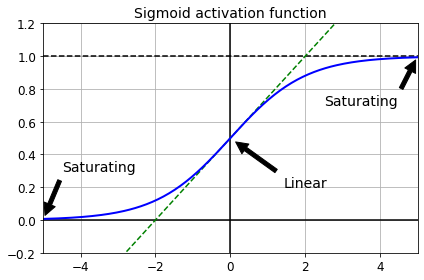

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## II. 불안정한 그레이디언트 문제를 해결하는 방법
- 크게 3가지의 초기화 방법이 나옴
  + 자세한 설명은 `교재 413~415 페이지` 참고 바람

| 초기화전략 	| 활성화 함수 | $\sigma^2`(정규분포)` $ 	|
|:-:	|:-:	|:-:	|
| 글로럿 	| 없음. 탄젠트, 로지스틱, 소프트맥스	| 1 / $fan_{avg}$ 	|
| He 	| `ReLU` 함수와 그 변종들	| 2 / $fan_{in}$ 	|
| 르쿤 	| SELU	| 1 / $fan_{in}$ 	|

- 케라스는 기본적으로 글로럿 초기화 사용
```python
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")
```

- $fan_{in}$ 대신 $fan_{out}$ 기반의 균등분포 `He` 초기화를 사용하고 싶다면 다음과 같이 `Variance Scaling`을 사용할 수 있다. 

```python
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=he_avg_init)
```


## III. 수렴하지 않는 활성화 함수
- 2010년 논문에서, 글로럿과 벤지오는 활성화 함수를 잘못 사용하면 그레이디언트의 소실이나 폭주로 이어질 수 있음
- 안타깝게도 `ReLU` 함수는 완벽하지 않음
  + 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는다는 의미에서 죽었다고 말함
  + 이를 보완하기 위해 다양한 `ReLU` 함수의 변종이 존재
    - LeakyReLU
    - RReLU
    - PReLU
  + 그 외에, `ELU`, `SELU` 활성화 함수도 있음
  + 이를 다 외울 필요는 없다. 
- 기본적으로는 `SELU`, `ELU`, `LeakyReLU` 내에서 사용하는 것을 권함
- 각 활성화 함수의 특징 및 장단점은 `교재 417~419 페이지 참조`

### (1) LeakyReLU를 활용한 모형 생성 및 평가
- 실전 예를 확인해보자. 


In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy:

그림 저장: keras_learning_curves_plot


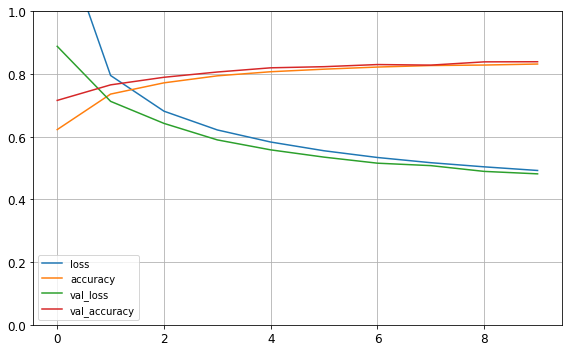

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5155 - accuracy: 0.8241


[0.5154786705970764, 0.8241000175476074]

## IV. 배치 정규화
- 배치 정규화 (`Batch Normalization(BN)`) 기법을 제안함
  + 마찬가지로 폭주 문제를 크게 감소시킬 수 있는 대안으로 제안됨
- 이 기법은 다음과 같이 작동됨
  + 이 작업을 할 때에는 각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가함. 
  + 이 연산은 단순하게 입력을 원점에 맞추고 정규화한 다음, 각 층에서 두개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동시킴. 
  + 즉, 하나는 스케일 조정, 다른 하나는 이동에 사용됨
  + 많은 경우, 훈련 세트를 표준화할 필요는 없음
  


### (1) 케라스로 배치 정규화 구현하기 (활성화 함수 이후)
- 은닉층의 활성화 함수 전이나 후에 `BatchNormalization`층을 추가하면 됨
- 아래 예제는 활성화 함수 이후에 배치 정규화 층을 추가하는 것임

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

- 모델에서 훈련되지 않는 `2,368`은 역전파로 학습되지 않는다는 뜻이다. 

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

- 첫번째 배치 정규화 층의 파라미터를 보면, 두 개는 (역전파로) 훈련되고 두 개는 훈련되지 않는다. 

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8293 - accuracy: 0.7221 - val_loss: 0.5539 - val_accuracy: 0.8160
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5703 - accuracy: 0.8036 - val_loss: 0.4792 - val_accuracy: 0.8380
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5161 - accuracy: 0.8213 - val_loss: 0.4424 - val_accuracy: 0.8490
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4789 - accuracy: 0.8314 - val_loss: 0.4212 - val_accuracy: 0.8570
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4548 - accuracy: 0.8407 - val_loss: 0.4051 - val_accuracy: 0.8616
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4387 - accuracy: 0.8445 - val_loss: 0.3931 - val_accuracy: 0.8632
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4255 - accuracy: 0.8502 - val_loss: 0.3829 - val_accuracy:

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3969 - accuracy: 0.8568


[0.39694663882255554, 0.8568000197410583]

### (2) 케라스로 배치 정규화 구현하기 (활성화 함수 이전)
- 이번에는 활성화 함수 이전에 배치 정규화를 지정한다. 
- 배치 정규화 층은 입력마다 이동 파라미터를 포함하기 때문에 이전 층에서 편향을 뺄 수 있음
  + 층을 만들 때 `use_bias=False`로 설정


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0346 - accuracy: 0.6739 - val_loss: 0.6680 - val_accuracy: 0.7886
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6757 - accuracy: 0.7818 - val_loss: 0.5537 - val_accuracy: 0.8212
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5961 - accuracy: 0.8021 - val_loss: 0.4996 - val_accuracy: 0.8350
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5456 - accuracy: 0.8175 - val_loss: 0.4655 - val_accuracy: 0.8460
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5140 - accuracy: 0.8249 - val_loss: 0.4420 - val_accuracy: 0.8508
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4915 - accuracy: 0.8309 - val_loss: 0.4238 - val_accuracy: 0.8538
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4742 - accuracy: 0.8375 - val_loss: 0.4103 - val_accuracy:

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4244 - accuracy: 0.8471


[0.42444711923599243, 0.847100019454956]

## V. 사전훈련된 층 재사용하기
- 아주 큰 규모의 `DNN`을 처음부터 새로 훈련하는 것은 좋은 생각이 아님. 
- 신경망의 하위층을 재사용하는 것이 좋음
  + 이를 전이 학습(`Transfer Learning`)이라고 함. 
- 상황 가정
  + 샌들과 셔츠를 제외한 8개의 클래스는 분류하는 `모델 A`를 만들었고, 약 90% 정확도를 얻었다. 
  + 이 때, 샌들과 셔츠 이미지를 구분하는 이진 분류기 `모델 B`를 만들었고, 약 97%의 정확도를 얻었다. 
  + 이 때, 더 좋은 성능을 얻기 위해 어떻게 해야 할까?

### (1) 사전 훈련 개요
- 패션 MNIST 훈련 세트를 두 개로 나누어 본다. 
  + `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
  + `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트
- 검증 세트와 테스트 세트도 이렇게 나눈다. 하지만 이미지 개수는 제한하지 않는다.
  + A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 본다. 
  + A 작업에서 B 작업으로 약간의 지식이 전달되기를 기대한다. 왜냐하면 A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷하기 때문이다. 
  + 하지만 `Dense` 층을 사용하기 때문에 동일한 위치에 나타난 패턴만 재사용할 수 있다(반대로 합성곱 층은 훨씬 많은 정보를 전송한다). 
  + 학습한 패턴을 이미지의 어느 위치에서나 감지할 수 있기 때문이다. CNN 장에서 자세히 알아 본다. 


### (2) 데이터셋 분리
- 샌달과 셔츠를 기준으로 데이터를 분리 하는 코드를 작성한다. 

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # 샌달 or 셔츠
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class [7, 8, 9]를 [5, 6, 7]로 이동
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # 이진 분류 task: 셔츠인가 (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

- 분리가 완료되면, 데이터의 크기를 확인해본다. 

In [ ]:
X_train_A.shape

(43986, 28, 28)

In [ ]:
X_train_B.shape

(200, 28, 28)

In [ ]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [ ]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

- 실험 재현성을 위한 코드를 작성한다. 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

### (3) A 모형 생성 및 학습
- 초기 모형을 만든다. 
- 모형을 학습한 후, 저장한다. `(my_model_A.h5)`
  + H5 파일은 `Hierarchical Data Format (HDF)`
  + H5 파일은 항공 우주, 물리학, 공학, 금융, 학술 연구, 유전체학, 천문학, 전자 기기 및 의료 분야에서 주로 사용된다. 

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3890 - val_accuracy: 0.8677
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3013 - val_accuracy: 0.8991
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2972 - accuracy: 0.8974 - val_loss: 0.2892 - val_accuracy: 0.9013
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2834 - accuracy: 0.9022 - val_loss: 0.2774 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2729 - accuracy: 0.9063 - val_loss: 0.2733 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2720 - val_accuracy:

In [ ]:
model_A.save("my_model_A.h5")

### (4) B 모형 생성 및 학습
- 이제 B 모형을 생성하고 학습해본다. 

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 27ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 13ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

### (5) 케라스를 사용한 전이 학습
- 먼저 `모델 A`를 로드하고 이 모델의 층을 기반으로 새로운 모델 `model_B_on_A`를 만든다. 
- 출력층만 제외 하고 모든 층을 재사용한다.

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

- `model_A`와 `model_B_on_A`는 일부 층을 공유함. 
- `model_B_on_A` 훈련 시에는 `model_A`도 영향을 받는다. 
- 이제 `모델 B`를 위해 `model_B_on_A`를 훈련할 수 있다. 
  + 그런데, 새로운 출력층이 초기화 되어 있으므로 큰 오차를 만든다. 
  + 이를 방지하기 위해, 처음 몇 번의 에포크 동안 재사용된 층을 동결하고, 새로운 층에게 적절한 가중치를 학습할 시간을 준다.
  + 이 때, 모든 층의 `trainable` 속성을 `False`로 지정하고 모델을 컴파일 한다. 


In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

### (6) 모형 학습
- 이제, 몇번의 에포크 동안 모형을 훈련할 수 있다. 
- 그리고, 재사용된 층의 동결을 해제하고 모델을 다시 컴파일 한다. 
- `모델 B`에 맞게 재사용된 층을 세밀하게 튜닝하기 위해 훈련을 계속한다. 

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 25ms/step - loss: 0.5759 - accuracy: 0.6550 - val_loss: 0.5812 - val_accuracy: 0.6379
Epoch 2/4
7/7 [==============================] - 0s 12ms/step - loss: 0.5396 - accuracy: 0.6750 - val_loss: 0.5439 - val_accuracy: 0.6826
Epoch 3/4
7/7 [==============================] - 0s 13ms/step - loss: 0.5029 - accuracy: 0.7250 - val_loss: 0.5121 - val_accuracy: 0.7150
Epoch 4/4
7/7 [==============================] - 0s 13ms/step - loss: 0.4716 - accuracy: 0.7550 - val_loss: 0.4835 - val_accuracy: 0.7333
Epoch 1/16
7/7 [==============================] - 0s 27ms/step - loss: 0.3938 - accuracy: 0.8150 - val_loss: 0.3452 - val_accuracy: 0.8641
Epoch 2/16
7/7 [==============================] - 0s 13ms/step - loss: 0.2787 - accuracy: 0.9350 - val_loss: 0.2600 - val_accuracy: 0.9270
Epoch 3/16
7/7 [==============================] - 0s 14ms/step - loss: 0.2079 - accuracy: 0.9650 - val_loss: 0.2111 - val_accuracy: 0.9554
Epoch 4/16
7/7 [===============

### (7) 모형 평가
- 이제 최종 점수를 확인한다. 
- 먼저 `model_B`의 성능을 확인한다. 

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.14084088802337646, 0.9704999923706055]

- 그리고, 전이학습 모델의 성능을 확인한다. 

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9930


[0.06821806728839874, 0.9929999709129333]

- 모형의 성능이 크게 확산되었음을 확인 했다. 

## VI. 고속 옵티마이저
- 아주 큰 심층 신경망의 훈련 속도는 심각하게 느려짐
  + 표준적인 경사 하강법 외의 다른 옵티마지어를 사용해본다. 
- 옵티마이저의 종류는 여러가지가 있다. 
  + 모멘텀 최적화
  + 네스테로프 가속 경사
  + AdaGrad 
  + RMSProp
  + Adam
  + Nadam
- 각각의 특징은 `교재 434~443`을 확인한다. 
- 옵티마이저를 사용하는 이유는 훈련의 속도를 높이기 위한 것

### (1) 벤치마킹
- 각각의 `Optimizer`의 성능을 비교하는 벤치마킹 코드를 작성한다. 

In [49]:
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pylab as plt
import numpy as np

- mnist 데이터를 불러온 후 훈련데이터와 테스트데이터로 분리한다. 

In [50]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape  

((60000, 28, 28), (60000, 10), (10000, 28, 28), (10000, 10))

- 데이터를 훈련시키는 함수를 작성한다. 

In [51]:
def train_mnist(optimizer):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=x_train[0].shape),
        keras.layers.Dense(250, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.categorical_crossentropy,
        metrics=['acc']
    )

    history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=False,
                    shuffle=True,
                    validation_data=(x_test, y_test))

    return history, model

- 아래 코드는 `optimizer` 종류에 따라 각각의 훈련 히스토리가 어떻게 변하는지 각각의 `List`에 담았다. 

In [52]:
mnist = {
  'sgd': {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': [], 'history': []},
  'rmsprop': {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': [], 'history': []},
  'adagrad': {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': [], 'history': []},
  'adam': {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': [], 'history': []}
}
for optimizer in ['sgd', 'rmsprop', 'adagrad', 'adam']:
    print('--- {} ---'.format(optimizer))
    for i in range(2):
        print('starting ', i)
        history, model = train_mnist(optimizer)
        train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=False)
        val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=False)
        mnist[optimizer]['loss'].append(train_loss)
        mnist[optimizer]['acc'].append(train_accuracy)
        mnist[optimizer]['val_loss'].append(val_loss)
        mnist[optimizer]['val_acc'].append(val_accuracy)
        mnist[optimizer]['history'].append(history)

--- sgd ---
starting  0
starting  1
--- rmsprop ---
starting  0
starting  1
--- adagrad ---
starting  0
starting  1
--- adam ---
starting  0
starting  1


- 각 모형의 결과값을 출력하는 코드를 작성했다. 

In [53]:
for opt in ['sgd', 'rmsprop', 'adagrad', 'adam']:
    for key in ['acc', 'val_acc', 'loss', 'val_loss']:
        print(opt, key, np.mean(mnist[opt][key]))

sgd acc 0.895841658115387
sgd val_acc 0.9036500155925751
sgd loss 0.37897732853889465
sgd val_loss 0.36478106677532196
rmsprop acc 0.9932583272457123
rmsprop val_acc 0.9764000177383423
rmsprop loss 0.02655513398349285
rmsprop val_loss 0.08304187655448914
adagrad acc 0.9117666780948639
adagrad val_acc 0.9156999886035919
adagrad loss 0.31952860951423645
adagrad val_loss 0.31258873641490936
adam acc 0.9960833191871643
adam val_acc 0.9763499796390533
adam loss 0.01956858392804861
adam val_loss 0.07723309472203255


- 실제 모형을 훈련시킬 때, 값을 시각화로 구현하여 과적합이 일어나는지 안 일어나는지 확인하는 코드를 작성했다. 
- 또한, 각 `Optimizer`의 성능을 비교하는 그래프를 작성했다. 

[]

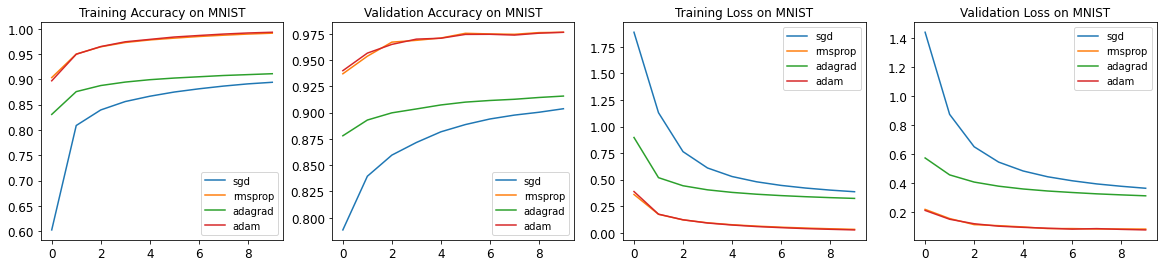

In [55]:
plt.figure(figsize=(20,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    key = ['acc', 'val_acc', 'loss', 'val_loss'][i]
    title = ['Training Accuracy on MNIST', 'Validation Accuracy on MNIST', 'Training Loss on MNIST', 'Validation Loss on MNIST'][i]
    for opt in ['sgd', 'rmsprop', 'adagrad', 'adam']:
        hist = np.zeros(10)
        for h in mnist[opt]['history']:
              hist += np.array(h.history[key])
        mean = hist / 2 # range(2) 값과 대응 시킨다. 
        plt.plot(mean, label=opt)
    plt.legend()
    plt.title(title)
plt.plot()

- 위 결과에서 보여주듯이, `Optimizer`를 사용한다면 `Adam` 또는 `RMSProp`를 우선 고려하는 것이 좋다. 


## VII. Reference
Wierenga, R. (2020, March 03). An Empirical Comparison of Optimizers for Machine Learning Models. Retrieved July 17, 2020, from https://heartbeat.fritz.ai/an-empirical-comparison-of-optimizers-for-machine-learning-models-b86f29957050